In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import PIL
import glob

## Mount Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
train_path='C:/Users/Shimul/Documents/Building CSE 4000 Thesis/Defense 27_03_2022/DATASET/train'
test_path='C:/Users/Shimul/Documents/Building CSE 4000 Thesis/Defense 27_03_2022/DATASET/test'
print(os.listdir(train_path))
print(os.listdir(test_path))

['brick_house', 'mosque', 'mud_house', 'skyscraper', 'temple', 'tinshed']
['brick_house', 'mosque', 'mud_house', 'skyscraper', 'temple', 'tinshed']


In [3]:
print(os.listdir(train_path))
print(os.listdir(test_path))

['brick_house', 'mosque', 'mud_house', 'skyscraper', 'temple', 'tinshed']
['brick_house', 'mosque', 'mud_house', 'skyscraper', 'temple', 'tinshed']


## Dataset Preparatin using ImageDataGenerator

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
WIDTH=224
HEIGHT=224

In [6]:
train_generator = ImageDataGenerator(rescale=1./255,
                                    horizontal_flip=True,
                                    shear_range=0.1 ,
                                    zoom_range=0.1,
                                    rotation_range=10,
                                    height_shift_range=0.1,
                                    fill_mode='nearest',
                                    validation_split=0.2)
                                     
train_dataset = train_generator.flow_from_directory(batch_size=32,
                                                 directory=train_path,
                                                 shuffle=True,
                                                 seed=1337,
                                                 target_size=(WIDTH, HEIGHT),
                                                 class_mode='categorical',
                                                 subset='training')

validation_dataset = train_generator.flow_from_directory(batch_size=32,
                                                 directory=train_path,
                                                 shuffle=True,
                                                 seed=1337,
                                                 target_size=(WIDTH, HEIGHT), 
                                                 class_mode='categorical',
                                                 subset='validation')

Found 960 images belonging to 6 classes.
Found 240 images belonging to 6 classes.


In [7]:
test_generator=ImageDataGenerator(rescale=1./255)
test_dataset = test_generator.flow_from_directory(batch_size=32,
                                                 directory=test_path,
                                                 shuffle=False,
                                                 seed=1337,
                                                 target_size=(WIDTH, HEIGHT), 
                                                 class_mode='categorical')

Found 300 images belonging to 6 classes.


In [9]:
train_dataset.class_indices

{'brick_house': 0,
 'mosque': 1,
 'mud_house': 2,
 'skyscraper': 3,
 'temple': 4,
 'tinshed': 5}

In [10]:
validation_dataset.class_indices

{'brick_house': 0,
 'mosque': 1,
 'mud_house': 2,
 'skyscraper': 3,
 'temple': 4,
 'tinshed': 5}

In [11]:
total_class=len(train_dataset.class_indices)
print('Number of classes in dataset: ',total_class)

Number of classes in dataset:  6


## Plot some random image
- class 0: brick house
- class 1: mosque
- class 2: mud house
- class 3: skyscraper
- class 4: temple
- class 5: tinshed

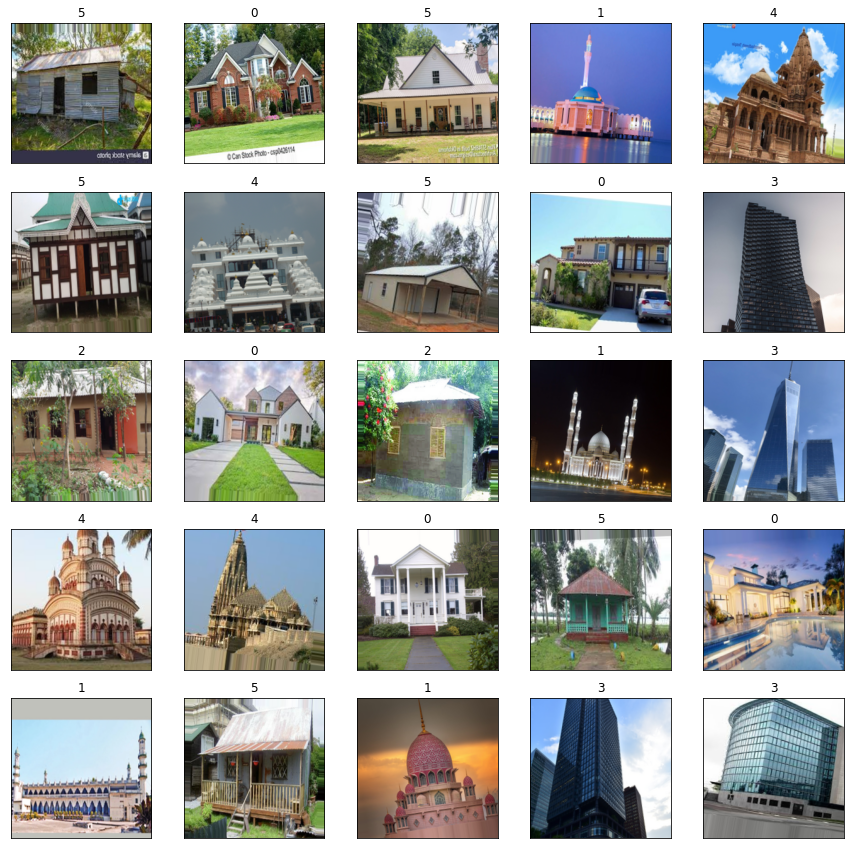

In [12]:
x,y=train_dataset.next()
fig=plt.figure(figsize=(15,15))
rows=5
cols=5
for i in range(rows*cols):
    fig.add_subplot(rows,cols,i+1)
    image=x[i]
    plt.imshow(image)
    plt.title(np.argmax(y[i]))
    plt.xticks([])
    plt.yticks([])
    
plt.show()

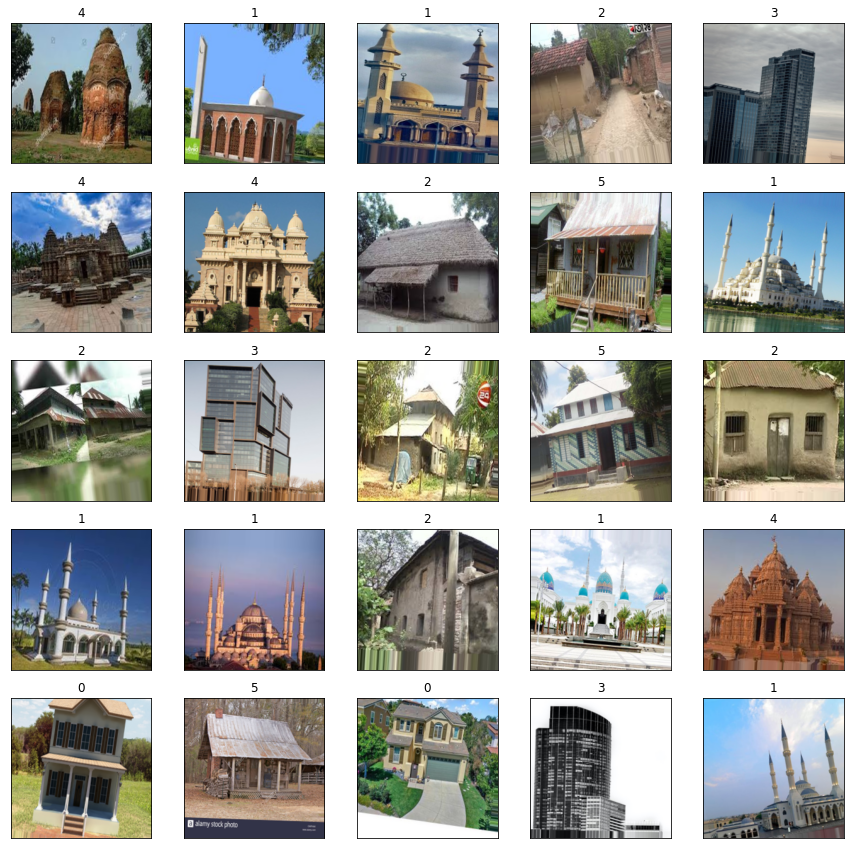

In [13]:
x,y=validation_dataset.next()
fig=plt.figure(figsize=(15,15))
rows=5
cols=5
for i in range(rows*cols):
    fig.add_subplot(rows,cols,i+1)
    image=x[i]
    plt.imshow(image)
    plt.title(np.argmax(y[i]))
    plt.xticks([])
    plt.yticks([])
    
plt.show()

## Import Library

In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

## Create conv relu batchnorm  Block

In [15]:
def conv_relu_batchnorm(x, filters, kernel_size):
    x = layers.Conv2D(filters=filters,
               kernel_size=kernel_size,
               activation='relu',
               padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    return x

## Define Concatenation Block

In [16]:
def layer_concate(tensor,filters):
    x=conv_relu_batchnorm(tensor,filters,kernel_size=3)
    x=layers.Concatenate()([x,tensor])
    return x

## Define Model Input

In [17]:
inputs=layers.Input(shape=(224,224,3))

## Inplement Model Architecture

In [18]:
total_class=6

In [19]:
x=conv_relu_batchnorm(inputs,filters=32,kernel_size=3)
x=layers.MaxPool2D(pool_size=(2,2))(x)
x=layer_concate(x,filters=64)

In [20]:
x=layers.MaxPool2D(pool_size=(3,3))(x)

In [21]:
x=conv_relu_batchnorm(x,filters=128,kernel_size=3)
x=layers.MaxPool2D(pool_size=(3,3))(x)
x=layer_concate(x,filters=256)
x=layers.MaxPool2D(pool_size=(3,3))(x)

In [22]:
"""
x=conv_relu_batchnorm(x,filters=256,kernel_size=3)
x=layer_concate(x,filters=256)
x = layers.GlobalAveragePooling2D()(x)
"""

'\nx=conv_relu_batchnorm(x,filters=256,kernel_size=3)\nx=layer_concate(x,filters=256)\nx = layers.GlobalAveragePooling2D()(x)\n'

In [23]:
x=layers.Dropout(0.2)(x)
x=layers.Flatten()(x)
x=layers.Dense(256,activation='relu')(x)

In [24]:
output=layers.Dense(total_class,activation='softmax')(x)

## Create Model

In [25]:
model=keras.Model(inputs,output,name='NewModel')

In [26]:
model.summary()

Model: "NewModel"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 224, 224, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 112, 112, 32) 0           batch_normalization[0][0]        
___________________________________________________________________________________________

In [27]:
import time
print(time.time())

1625192490.7403438


In [28]:
t=time.time()
image_name='/content/drive/MyDrive/CSE 4000 Thesis/Complex DNN Architecture/NewModelKUET'+str(int(t))+'.png'
image_name

'/content/drive/MyDrive/CSE 4000 Thesis/Complex DNN Architecture/NewModelKUET1625192490.png'

/content/drive/MyDrive/CSE 4000 Thesis/Complex DNN Architecture/NewModelKUET1625192490.png


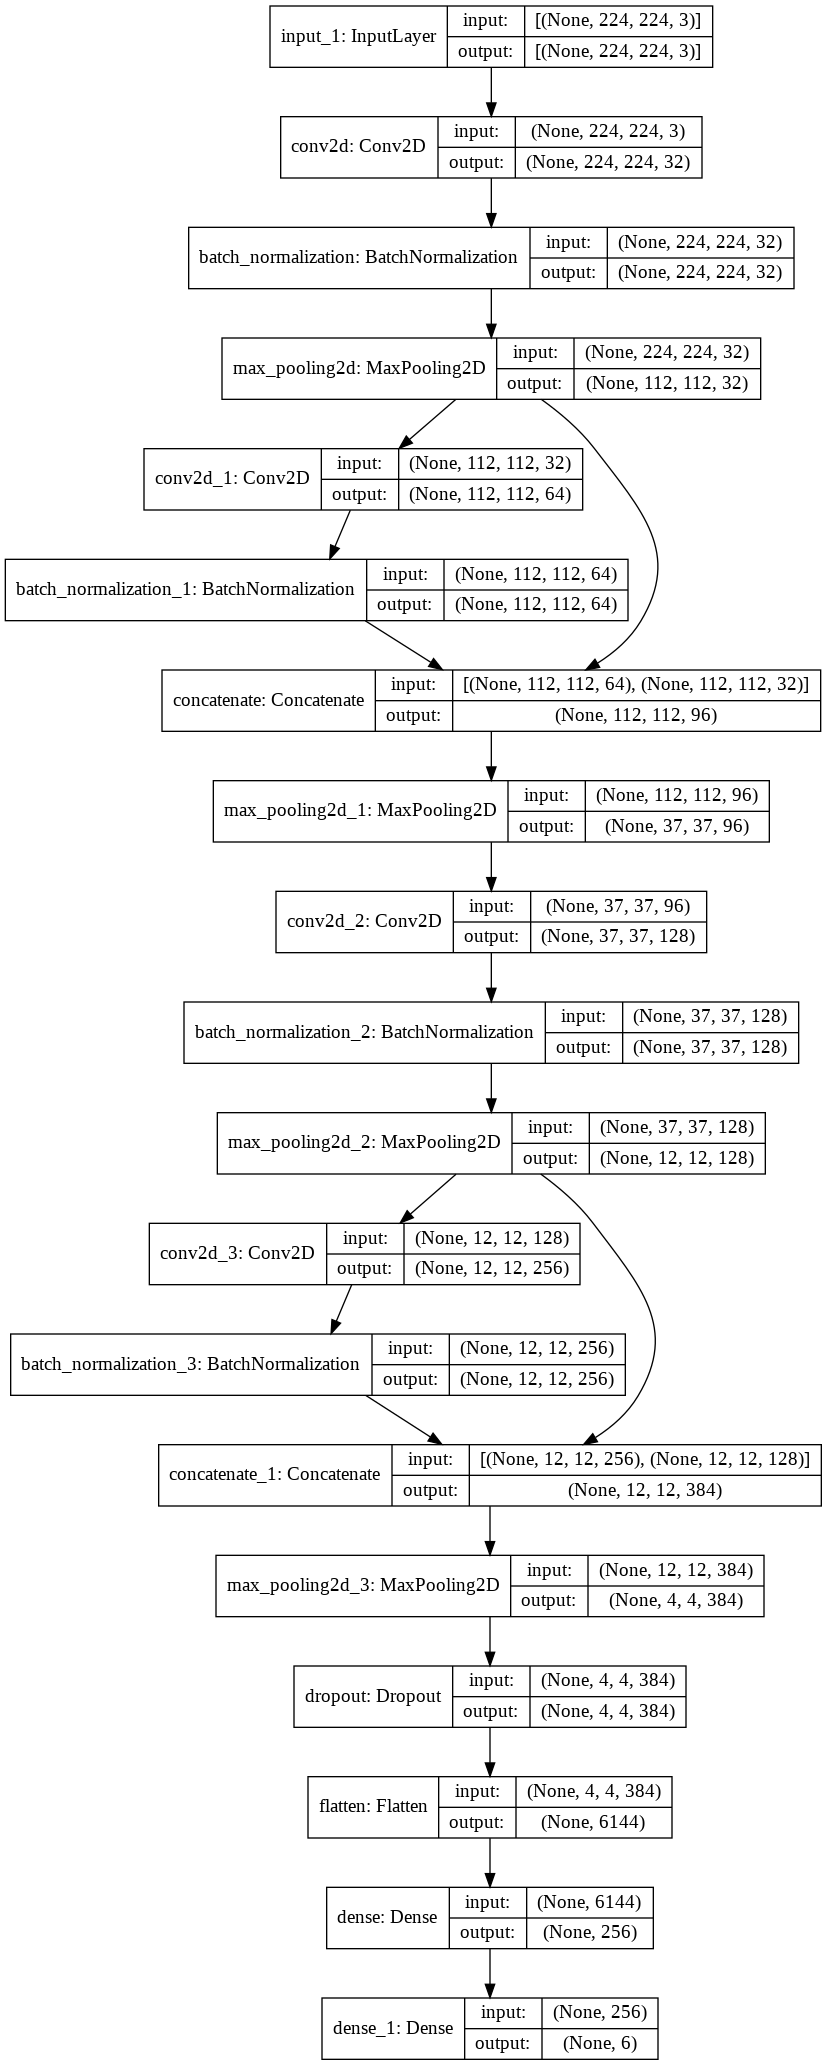

In [29]:
t=time.time()
image_name='/content/drive/MyDrive/CSE 4000 Thesis/Complex DNN Architecture/NewModelKUET'+str(int(t))+'.png'
print(image_name)
keras.utils.plot_model(model,show_shapes=True,to_file=image_name)

## Compile the Model

In [30]:
## Compile The Model 

In [31]:
model.compile(loss='categorical_crossentropy' ,
              optimizer='adam' ,
              metrics=['accuracy',
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall(),
                       tf.keras.metrics.AUC()])

## Trained the Model

In [32]:
epochs=200
batch_size=32
trainset_length=len(train_dataset.labels)
validation_length=len(validation_dataset.labels)
steps_per_epoch=(trainset_length//batch_size)
validation_steps=(validation_length//batch_size)
print(trainset_length)
print(validation_length)
print(steps_per_epoch)
print(validation_steps)

960
240
30
7


In [33]:
from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath='/content/drive/MyDrive/CSE 4000 Thesis/Transfer Learning TF Keras/buildingCNN.model.best.hdf5', verbose=1 ,save_best_only=True)

In [34]:
history = model.fit(train_dataset,
                    steps_per_epoch = steps_per_epoch,
                    epochs=epochs,
                    validation_data=validation_dataset,
                    validation_steps=validation_steps,
                    callbacks=[checkpointer])

Epoch 1/200
30/30 [==============================] - 22s 587ms/step - loss: 6.0362 - accuracy: 0.3708 - precision: 0.3914 - recall: 0.3135 - auc: 0.6906 - val_loss: 2.9860 - val_accuracy: 0.1741 - val_precision: 0.1875 - val_recall: 0.1741 - val_auc: 0.5580

Epoch 00001: val_loss improved from inf to 2.98596, saving model to /content/drive/MyDrive/CSE 4000 Thesis/Transfer Learning TF Keras/buildingCNN.model.best.hdf5
Epoch 2/200
30/30 [==============================] - 17s 566ms/step - loss: 1.1347 - accuracy: 0.5583 - precision: 0.7054 - recall: 0.3917 - auc: 0.8679 - val_loss: 5.5666 - val_accuracy: 0.1830 - val_precision: 0.1866 - val_recall: 0.1741 - val_auc: 0.5551

Epoch 00002: val_loss did not improve from 2.98596
Epoch 3/200
30/30 [==============================] - 17s 556ms/step - loss: 0.9691 - accuracy: 0.6250 - precision: 0.7311 - recall: 0.5240 - auc: 0.9053 - val_loss: 7.0689 - val_accuracy: 0.1652 - val_precision: 0.1721 - val_recall: 0.1652 - val_auc: 0.5264

Epoch 0000

## Plot the Graphs

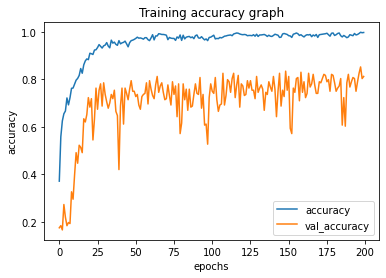

In [35]:
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Training accuracy graph')
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.legend()
plt.show()

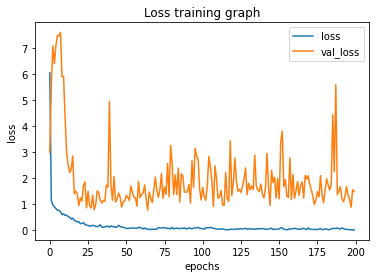

In [36]:
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Loss training graph')
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.legend()
plt.show()


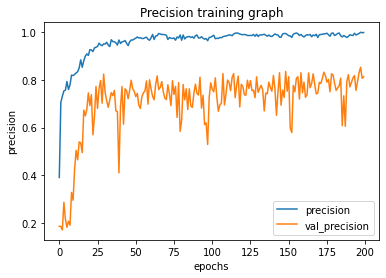

In [37]:
plt.xlabel('epochs')
plt.ylabel('precision')
plt.title('Precision training graph')
plt.plot(history.history['precision'],label='precision')
plt.plot(history.history['val_precision'],label='val_precision')
plt.legend()
plt.show()

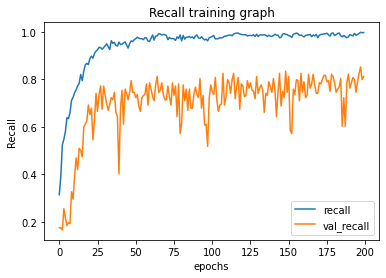

In [38]:
plt.xlabel('epochs')
plt.ylabel('Recall')
plt.title('Recall training graph')
plt.plot(history.history['recall'],label='recall')
plt.plot(history.history['val_recall'],label='val_recall')
plt.legend()
plt.show()

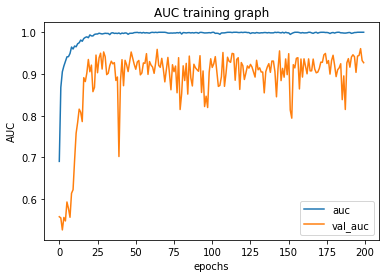

In [39]:
plt.xlabel('epochs')
plt.ylabel('AUC')
plt.title('AUC training graph')
plt.plot(history.history['auc'],label='auc')
plt.plot(history.history['val_auc'],label='val_auc')
plt.legend()
plt.show()

In [40]:
test_loss,test_accuracy,test_precision,test_recall,test_auc=model.evaluate(test_dataset)

10/10 [==============================] - 2s 161ms/step - loss: 1.7003 - accuracy: 0.8467 - precision: 0.8467 - recall: 0.8467 - auc: 0.9336


In [41]:
print('Accuracy of the model is : ',test_accuracy*100)
print('Loss of the model is : ',test_loss)
print('Precision of the model is : ',test_precision*100)
print('Recall of the model is : ',test_recall*100)
print('AUC of the model is : ',test_auc*100)

Accuracy of the model is :  84.6666693687439
Loss of the model is :  1.7003040313720703
Precision of the model is :  84.6666693687439
Recall of the model is :  84.6666693687439
AUC of the model is :  93.35533380508423


In [42]:
f1score=(2*test_precision*test_recall)/ (test_precision+test_recall)
print("F1 score: ",f1score*100)

F1 score:  84.6666693687439


## Testing the Model With Image

In [33]:
from tensorflow.keras.preprocessing import image

(1, 224, 224, 3)
[[9.9999797e-01 8.0234805e-08 2.9782685e-09 8.4329592e-13 5.1472887e-10
  1.8971703e-06]]
0


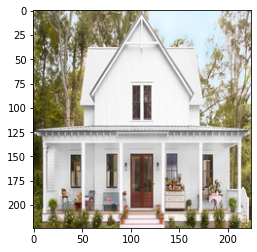

In [68]:
image_path='/content/drive/MyDrive/CSE 4000 Thesis/Dataset1500/Images/building_house5.png'
random_image=image.load_img(image_path,target_size=(224,224))
plt.imshow(random_image)
random_image=image.img_to_array(random_image)
test_image=random_image.reshape((1,)+random_image.shape)
test_image=test_image/255.0
print(test_image.shape)
predicted_class=model.predict(test_image)
print(predicted_class)
#print('True classification')
print(np.argmax(predicted_class))

(1, 224, 224, 3)
[[2.6790671e-13 2.1894334e-03 1.1174393e-15 8.6441300e-16 9.9781054e-01
  2.9202361e-15]]
4


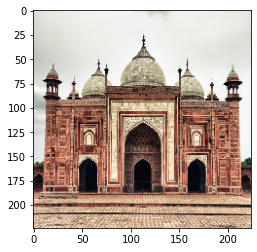

In [69]:
image_path='/content/drive/MyDrive/CSE 4000 Thesis/Dataset1500/Images/mosque35.png'
random_image=image.load_img(image_path,target_size=(224,224))
plt.imshow(random_image)
random_image=image.img_to_array(random_image)
test_image=random_image.reshape((1,)+random_image.shape)
test_image=test_image/255.0
print(test_image.shape)
predicted_class=model.predict(test_image)
print(predicted_class)
#print('True classification')
print(np.argmax(predicted_class))

(1, 224, 224, 3)
[[2.9632552e-15 1.0000000e+00 1.7868986e-17 2.9243756e-17 1.8948296e-09
  9.3448641e-19]]
1


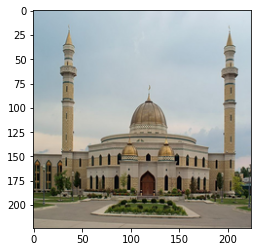

In [75]:
image_path='/content/drive/MyDrive/CSE 4000 Thesis/Dataset1500/Images/mosque0.png'
random_image=image.load_img(image_path,target_size=(224,224))
plt.imshow(random_image)
random_image=image.img_to_array(random_image)
test_image=random_image.reshape((1,)+random_image.shape)
test_image=test_image/255.0
print(test_image.shape)
predicted_class=model.predict(test_image)
print(predicted_class)
#print('True classification')
print(np.argmax(predicted_class))

(1, 224, 224, 3)
[[5.1669542e-17 2.5671813e-18 1.0000000e+00 7.1019334e-19 1.4954317e-10
  1.4013404e-11]]
2


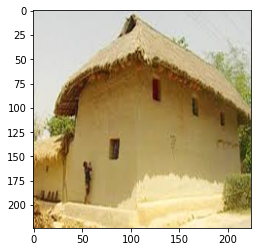

In [70]:
image_path='/content/drive/MyDrive/CSE 4000 Thesis/Dataset1500/Images/mud72.png'
random_image=image.load_img(image_path,target_size=(224,224))
plt.imshow(random_image)
random_image=image.img_to_array(random_image)
test_image=random_image.reshape((1,)+random_image.shape)
test_image=test_image/255.0
print(test_image.shape)
predicted_class=model.predict(test_image)
print(predicted_class)
#print('True classification')
print(np.argmax(predicted_class))

(1, 224, 224, 3)
[[3.2429995e-37 8.1792183e-38 0.0000000e+00 1.0000000e+00 1.2921992e-34
  0.0000000e+00]]
3


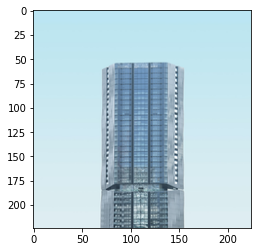

In [71]:
image_path='/content/drive/MyDrive/CSE 4000 Thesis/Dataset1500/Images/sky79.png'
random_image=image.load_img(image_path,target_size=(224,224))
plt.imshow(random_image)
random_image=image.img_to_array(random_image)
test_image=random_image.reshape((1,)+random_image.shape)
test_image=test_image/255.0
print(test_image.shape)
predicted_class=model.predict(test_image)
print(predicted_class)
#print('True classification')
print(np.argmax(predicted_class))

(1, 224, 224, 3)
[[1.7643486e-26 2.5270651e-16 3.7730999e-21 1.7192241e-24 1.0000000e+00
  6.2740652e-25]]
4


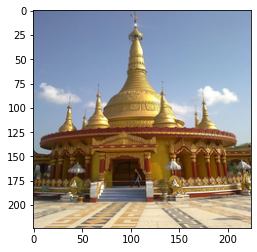

In [72]:
image_path='/content/drive/MyDrive/CSE 4000 Thesis/Dataset1500/Images/temple33.png'
random_image=image.load_img(image_path,target_size=(224,224))
plt.imshow(random_image)
random_image=image.img_to_array(random_image)
test_image=random_image.reshape((1,)+random_image.shape)
test_image=test_image/255.0
print(test_image.shape)
predicted_class=model.predict(test_image)
print(predicted_class)
#print('True classification')
print(np.argmax(predicted_class))

(1, 224, 224, 3)
[[1.4764044e-11 6.7530287e-12 1.2155355e-06 7.4772454e-12 1.3840635e-06
  9.9999738e-01]]
5


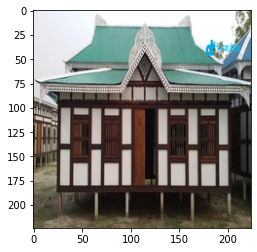

In [73]:
image_path='/content/drive/MyDrive/CSE 4000 Thesis/Dataset1500/Images/tinshed25.png'
random_image=image.load_img(image_path,target_size=(224,224))
plt.imshow(random_image)
random_image=image.img_to_array(random_image)
test_image=random_image.reshape((1,)+random_image.shape)
test_image=test_image/255.0
print(test_image.shape)
predicted_class=model.predict(test_image)
print(predicted_class)
#print('True classification')
print(np.argmax(predicted_class))

(1, 224, 224, 3)
[[3.1768690e-13 8.8503057e-08 3.8550107e-13 4.2673935e-09 9.9999988e-01
  8.1979576e-16]]
4


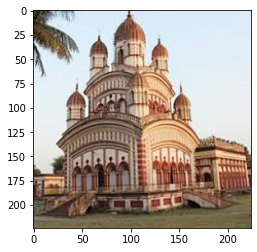

In [76]:
image_path='/content/drive/MyDrive/CSE 4000 Thesis/Dataset1500/Images/temple72.png'
random_image=image.load_img(image_path,target_size=(224,224))
plt.imshow(random_image)
random_image=image.img_to_array(random_image)
test_image=random_image.reshape((1,)+random_image.shape)
test_image=test_image/255.0
print(test_image.shape)
predicted_class=model.predict(test_image)
print(predicted_class)
#print('True classification')
print(np.argmax(predicted_class))

## Saved Model

In [43]:
import time
t = time.time()

export_path_keras = "/content/drive/MyDrive/CSE 4000 Thesis/Complex DNN Architecture/NewModelKUET{}_model_{}.h5".format(test_accuracy,int(t))
print(export_path_keras)
model.save(export_path_keras)

/content/drive/MyDrive/CSE 4000 Thesis/Complex DNN Architecture/NewModelKUET0.846666693687439_model_1625195819.h5


In [44]:
#export_path_keras= '/content/drive/MyDrive/CSE 4000 Thesis/Complex DNN Architecture/NewModelKUET0.7699999809265137_model_1625137984.h5'

In [10]:
from tensorflow.keras.models import load_model

In [8]:
export_path_keras='SavedModel/NewModelKUET0.846666693687439_model_1625195819.h5'

In [11]:
model_path=export_path_keras
reload_model=load_model(model_path)
reload_model.summary()


Model: "NewModel"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 224, 224, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 112, 112, 32) 0           batch_normalization[0][0]        
___________________________________________________________________________________________

In [12]:
model=reload_model

## Experiment on relaod model

- class 0: brick house
- class 1: mosque
- class 2: mud house
- class 3: skyscraper
- class 4: temple
- class 5: tinshed

In [13]:
from tensorflow.keras.preprocessing import image

(1, 224, 224, 3)
[[2.6790874e-13 2.1894418e-03 1.1174437e-15 8.6440644e-16 9.9781054e-01
  2.9202473e-15]]
4


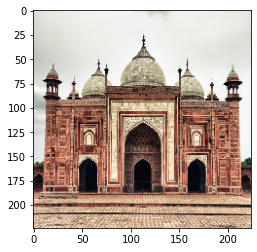

In [17]:
image_path='C:/Users/Shimul/Documents/Building CSE 4000 Thesis/Defense 27_03_2022/Images/mosque35.png'
random_image=image.load_img(image_path,target_size=(224,224))
plt.imshow(random_image)
random_image=image.img_to_array(random_image)
test_image=random_image.reshape((1,)+random_image.shape)
test_image=test_image/255.0
print(test_image.shape)
predicted_class=model.predict(test_image)
print(predicted_class)
#print('True classification')
print(np.argmax(predicted_class))

(1, 224, 224, 3)
[[2.9632440e-15 1.0000000e+00 1.7868986e-17 2.9243756e-17 1.8948296e-09
  9.3448641e-19]]
1


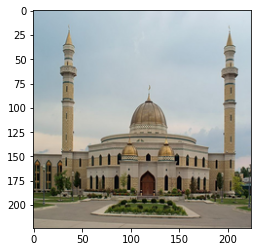

In [18]:
image_path='C:/Users/Shimul/Documents/Building CSE 4000 Thesis/Defense 27_03_2022/Images/mosque0.png'
random_image=image.load_img(image_path,target_size=(224,224))
plt.imshow(random_image)
random_image=image.img_to_array(random_image)
test_image=random_image.reshape((1,)+random_image.shape)
test_image=test_image/255.0
print(test_image.shape)
predicted_class=model.predict(test_image)
print(predicted_class)
#print('True classification')
print(np.argmax(predicted_class))

(1, 224, 224, 3)
[[3.8043436e-12 9.6143682e-18 7.7494002e-15 4.9233400e-05 9.9995077e-01
  7.0251837e-15]]
4


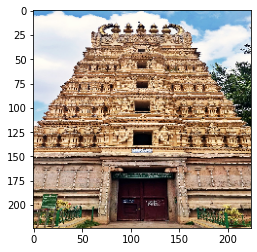

In [41]:
image_path='C:/Users/Shimul/Documents/Building CSE 4000 Thesis/Defense 27_03_2022/Images/temple.jpg'
random_image=image.load_img(image_path,target_size=(224,224))
plt.imshow(random_image)
random_image=image.img_to_array(random_image)
test_image=random_image.reshape((1,)+random_image.shape)
test_image=test_image/255.0
print(test_image.shape)
predicted_class=model.predict(test_image)
print(predicted_class)
#print('True classification')
print(np.argmax(predicted_class))

## Classification Report

In [25]:
predicted_result=model.predict(test_dataset)
predicted_result[:5]

array([[9.7637367e-01, 1.1519350e-09, 4.8317030e-09, 1.8344530e-13,
        7.7040645e-04, 2.2855885e-02],
       [9.9999440e-01, 6.3612617e-09, 6.8660327e-11, 6.4280437e-15,
        3.2007194e-12, 5.5999103e-06],
       [9.9999928e-01, 2.9150533e-08, 2.8632667e-11, 2.0453711e-15,
        7.0835317e-11, 6.8206305e-07],
       [9.9997318e-01, 7.5132625e-08, 1.1981161e-10, 8.4159339e-15,
        4.7010520e-08, 2.6659400e-05],
       [9.9448121e-01, 1.3729021e-10, 1.6271390e-11, 6.6198192e-17,
        8.5381259e-08, 5.5186315e-03]], dtype=float32)

In [26]:
predicted_value=np.argmax(model.predict(test_dataset),axis=-1)
predicted_value

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0,
       5, 0, 0, 0, 0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4,
       0, 0, 0, 5, 0, 0, 1, 1, 1, 1, 1, 0, 4, 1, 1, 3, 1, 1, 1, 1, 2, 1,
       1, 4, 1, 1, 1, 1, 1, 4, 1, 1, 1, 5, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 3, 1, 4, 1, 4, 1, 1, 3, 4, 2, 5, 2, 2, 2, 2, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 5, 1, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 5, 4, 4, 4,
       4, 4, 4, 4, 4, 0, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5], d

In [27]:
test_value=test_dataset.classes
test_value

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5])

In [28]:
from sklearn.metrics import accuracy_score
print('Accuracy score: ',accuracy_score(test_dataset.classes,predicted_value))

Accuracy score:  0.8466666666666667


In [29]:
from sklearn.metrics import classification_report
print('classification report \n',classification_report(test_dataset.classes,predicted_value))

classification report 
               precision    recall  f1-score   support

           0       0.85      0.56      0.67        50
           1       0.95      0.74      0.83        50
           2       0.96      0.94      0.95        50
           3       0.94      1.00      0.97        50
           4       0.86      0.86      0.86        50
           5       0.64      0.98      0.78        50

    accuracy                           0.85       300
   macro avg       0.87      0.85      0.84       300
weighted avg       0.87      0.85      0.84       300



## Confusion Matrix

In [30]:
from sklearn.metrics import confusion_matrix
cm_matrix=confusion_matrix(test_dataset.classes,predicted_value)
cm_matrix

array([[28,  0,  0,  0,  1, 21],
       [ 2, 37,  1,  3,  6,  1],
       [ 0,  1, 47,  0,  0,  2],
       [ 0,  0,  0, 50,  0,  0],
       [ 3,  1,  0,  0, 43,  3],
       [ 0,  0,  1,  0,  0, 49]], dtype=int64)

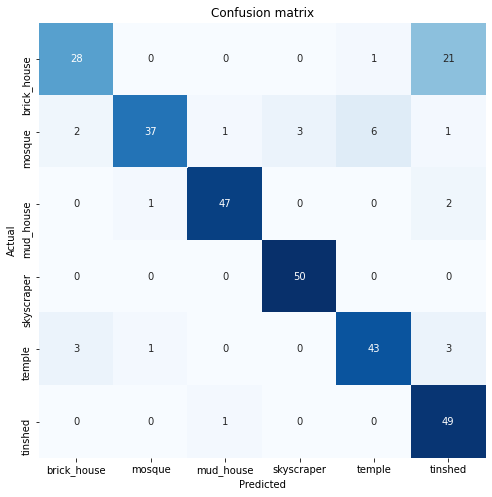

In [31]:
classnames = ['brick_house', 'mosque','mud_house', 'skyscraper', 'temple', 'tinshed']
import seaborn as sns
plt.figure(figsize=(8,8))
plt.title('Confusion matrix')
sns.heatmap(cm_matrix, cbar=False, xticklabels=classnames, yticklabels=classnames, fmt='d', annot=True, cmap=plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()